1. Dealing with errors
2. Annotating code
3. Generating code snippets
4. Explaining code

Using `xarray` or some NetCDF file.

https://earth.gsfc.nasa.gov/cryo/data/current-state-sea-ice-cover

https://nsidc.org/data/nsidc-0079/versions/4#anchor-documentation


Sea ice concentration is the percent areal coverage of ice within the data element (grid cell). 

In [1]:
import os
from pathlib import Path

import pandas as pd
import xarray as xr
import rioxarray as rioxr

Initially got an error message not being able to opend the file because of missing an engine. 

```
xr.open_dataset('NSIDC0079_SEAICE_PS_N25km_202001_v4.0.nc', engine="netcdf4")
```

Followed instructions from xarray website to troubleshoot:
https://docs.xarray.dev/en/stable/user-guide/io.html
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

These links were given by the error. 
Installed necdf4 in current environment.

Then I switched to `rioxarray` because `xarray` did not parse the geospatial info directly.

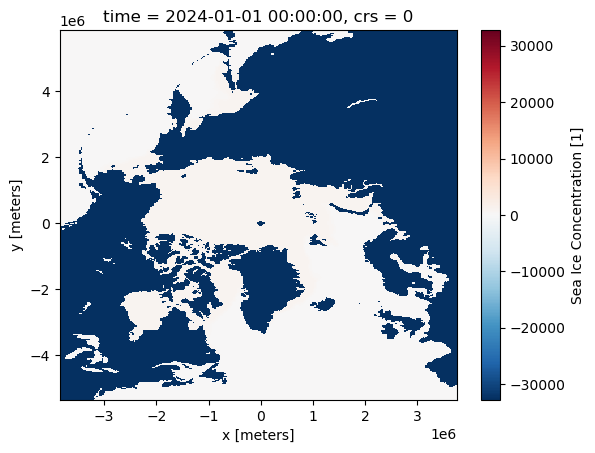

In [2]:
data = rioxr.open_rasterio(os.path.join('monthly_data', 'NSIDC0079_SEAICE_PS_N25km_202401_v4.0.nc'))
data.plot()

In [29]:
data.squeeze()

<xarray.DataArray 'F17_ICECON' (y: 448, x: 304)> Size: 272kB
array([[     0,      0,      0, ..., -32767, -32767, -32767],
       [     0,      0,      0, ..., -32767, -32767, -32767],
       [     0,      0,      0, ..., -32767, -32767, -32767],
       ...,
       [-32767, -32767, -32767, ...,      0,      0,      0],
       [-32767, -32767, -32767, ...,      0,      0,      0],
       [-32767, -32767, -32767, ...,      0,      0,      0]], dtype=int16)
Coordinates:
  * x        (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y        (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
    time     object 8B 2024-01-01 00:00:00
    crs      int64 8B 0
Attributes: (12/65)
    acknowledgment:                  These data are produced by the NASA Cryo...
    cdm_data_type:                   Grid
    citation:                        Comiso, J.C., Gersten, R.A. (2023). Boot...
    contributor_name:                Joey Comiso, Robert Gersten, Hannah Wilc...
    contributor_role:                project_scientist, project_scientist, sc...
    Conventions:                     CF-1.10, ACDD-1.3
    ...                              ...
    flag_meanings:                   missing land
    packing_convention:              netCDF
    packing_convention_description:  unpacked = scale_factor*packed + add_offset
    scale_factor:                    0.001
    add_offset:                      0.0
    _FillValue:                      -32767

In [4]:
# Investigate if there are pixels with missing data
print(f"Number of pixels with missing data: {(data==1100).sum().item()}")
print(f"Number of pixels with primarily land or permanent ice-shelf: {(data==1200).sum().item()}")

# This was a cool third line that got automatically suggested by the AI doing what I wanted
print(f"Percent of pixels with data: {(data!=data.attrs['_FillValue']).sum().item() / data.size * 100:.2f}%") 

Number of pixels with missing data: 0
Number of pixels with primarily land or permanent ice-shelf: 0
Percent of pixels with data: 49.86%


In [5]:
(data==data.attrs['_FillValue'])

<xarray.DataArray 'F17_ICECON' (time: 1, y: 448, x: 304)> Size: 136kB
array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]])
Coordinates:
  * x        (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y        (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time     (time) object 8B 2024-01-01 00:00:00
    crs      int64 8B 0

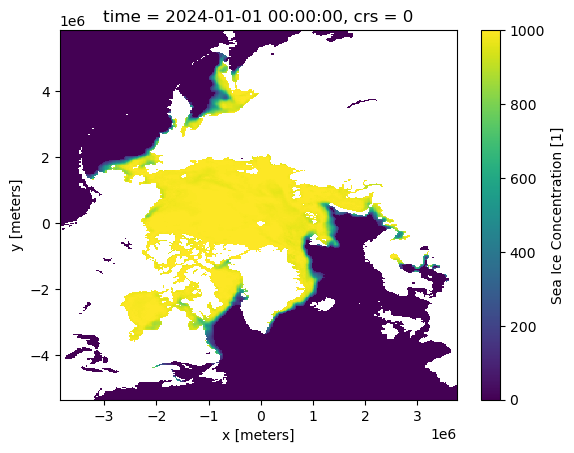

In [6]:
sea_ice = data.where(data!=data.attrs['_FillValue'])
sea_ice.plot()

In [7]:
# ALL OF THIS GOT SUGGESTED BY COPILOT AFTER I ASKED:
# Integral sum of the areas of all grid cells with at least 15% sea ice concentration
# Grid cells with at least 15% sea ice concentration 
sea_ice_15 = sea_ice.where(sea_ice >= 150)
# Each grid cell is 25 km x 25 km = 625 km^2
area_per_cell_km2 = 25 * 25
# Count the number of grid cells with at least 15% sea ice concentration
num_cells_15 = (sea_ice_15 >= 150).sum().item()
# Total area with at least 15% sea ice concentration
total_area_15_km2 = num_cells_15 * area_per_cell_km2
print(f"Total area with at least 15% sea ice concentration: {total_area_15_km2} km²")

Total area with at least 15% sea ice concentration: 14193750 km²


In [8]:
print(sea_ice.attrs['geospatial_x_resolution'], ',', sea_ice.attrs['geospatial_y_resolution'])
print(sea_ice.rio.resolution())

area_per_cell_km2 = sea_ice.rio.resolution()[0] * -sea_ice.rio.resolution()[1] / 1e6  # Convert m² to km²
sea_ice_extent = (sea_ice >= 150).sum().item() * area_per_cell_km2
print(f"Sea ice extent (Total area with at least 15% sea ice concentration): {sea_ice_extent:,.2f} km²")  # Here I did the "commas" and accepted the suggestion

25000.0 meters , 25000.0 meters
(25000.0, -25000.0)
Sea ice extent (Total area with at least 15% sea ice concentration): 14,193,750.00 km²


# Calculating sea ice extent for every month in 2020 

In [ ]:
# All this code got suggested by Copilot after I started typing data_dir...
data_dir = Path('monthly_data')
data_files = list(data_dir.glob('NSIDC0079_SEAICE_PS_N25km_*.nc'))
data_files.sort()

Signature: data_dir.glob(pattern)
Docstring:
Iterate over this subtree and yield all existing files (of any
kind, including directories) matching the given relative pattern.
File:      /opt/anaconda3/envs/eds220-env/lib/python3.11/pathlib.py
Type:      method

In [10]:
# Simplified version
data_files = sorted(Path('monthly_data').glob('NSIDC0079_SEAICE_PS_N25km_*.nc'))
data_files

[PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202401_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202402_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202403_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202404_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202405_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202406_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202407_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202408_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202409_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202410_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202411_v4.0.nc'),
 PosixPath('monthly_data/NSIDC0079_SEAICE_PS_N25km_202412_v4.0.nc')]

In [38]:
sea_ice_24 = xr.open_mfdataset(data_files, chunks=None).compute()  # I don't want the chunks
sea_ice_24

<xarray.Dataset> Size: 13MB
Dimensions:     (time: 12, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 13MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    crs         (time) |S1 12B b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_x_resolution:   25000.0 meters
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0

In [ ]:
# This code was suggested by copilot after typing the first sea_ice_extent line
sea_ice_extent = (sea_ice_24 >= 0.15).sum(dim=['x', 'y']) * area_per_cell_km2
sea_ice_extent_df = sea_ice_extent.to_dataframe(name='sea_ice_extent_km2').reset_index()
sea_ice_extent_df

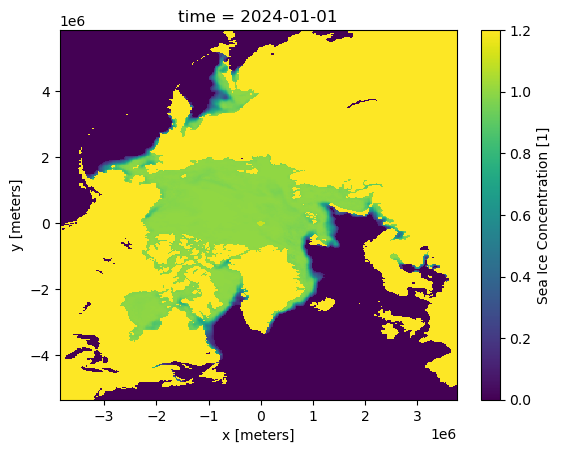

In [32]:
ice24 = sea_ice_24['F17_ICECON'].sel(time='2024-01-01')
ice24.plot()

<BarContainer object of 50 artists>

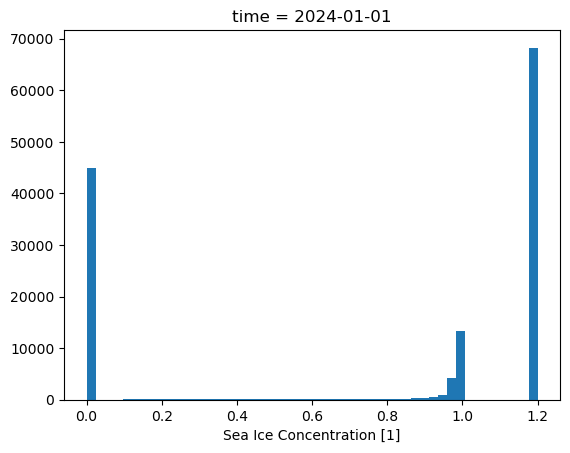

In [35]:
# Create a histogram with the data in ice24
ice24.plot.hist(bins=50)[2]

<BarContainer object of 50 artists>

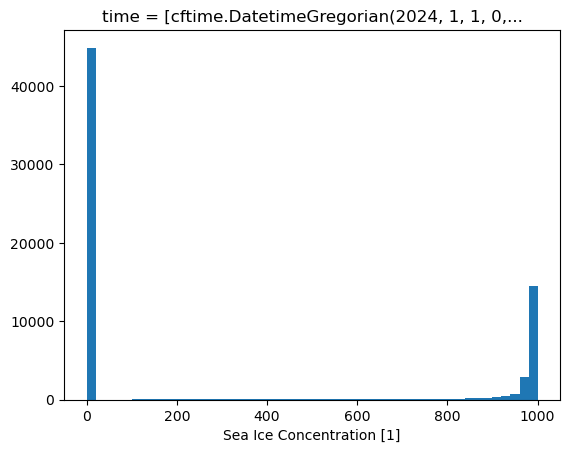

In [36]:
sea_ice.plot.hist(bins=50)[2]

In [37]:
sea_ice_24["F17_ICECON"].encoding


{'dtype': dtype('int16'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 448, 304),
 'preferred_chunks': {'time': 1, 'y': 448, 'x': 304},
 'source': '/Users/c_galazgarcia/Documents/code-for-genAI-demo/monthly_data/NSIDC0079_SEAICE_PS_N25km_202401_v4.0.nc',
 'original_shape': (1, 448, 304),
 'scale_factor': 0.001,
 'add_offset': 0.0,
 'coordinates': 'time y x'}

In [51]:
# Then I tried this and still not what I wanted, had to add the compute() to get past the dask chunks 
sea_ice_extent = ((sea_ice_24['F17_ICECON']>=0.15) & (sea_ice_24['F17_ICECON']<=1) ).sum(dim=['x', 'y']) * area_per_cell_km2


<Axes: xlabel='time'>

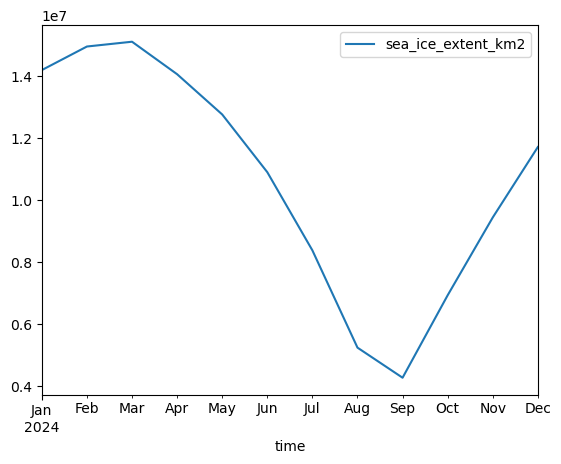

In [55]:
sea_ice_extent.to_dataframe(name='sea_ice_extent_km2').plot()